## 電腦視覺馬拉松期末作業

使用浣熊及袋鼠的資料集訓練yolo v3的物件偵測模型。

1. [資料前處理](#1)
2. [訓練模型](#2)
3. [驗證結果](#3)

In [1]:
# 訓練模型前一定要確認要使用的GPU是空閒的，才不會影響到其他人使用
!nvidia-smi

Fri Feb 21 08:23:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.98                 Driver Version: 384.98                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0  On |                  N/A |
| 26%   42C    P8    18W / 250W |   9979MiB / 11170MiB |     36%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
| 26%   43C    P8    16W / 250W |   2492MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
#我的環境
import tensorflow as tf
import sys
print('tensorflow version:', tf.__version__)
print('python version:', sys.version)

tensorflow version: 1.3.0
python version: 3.5.2 (default, Sep 14 2017, 22:51:06) 
[GCC 5.4.0 20160609]


<a id='1'></a>

## 資料前處理

首先，先將Day039_keras-yolo3所使用到的repo下載下來，並下載浣熊和袋鼠資料集，https://github.com/experiencor/raccoon_dataset 、 https://github.com/experiencor/kangaroo 。

資料夾階層為:

day049-050 ---data(訓練資料位置)

          └--font(標記框線時所需使用的字體檔)
          
          └--logs(模型訓練紀錄及位置)
          
          └--model_data(愈訓練模型及初始化參數)
          
          └--yolo3(yolo核心函式)
          
          └--animal.txt(訓練資料及label)
          
          └--final.ipynb(此程式碼)
          
          └--Kangaroo.mp4(袋鼠測試影片)
          
          └--Raccoon.mp4(浣熊測試影片)
          
          └--train.py(yolo訓練函式)
          
          └--yolo.py(yolo預測函式)
          
          
由於浣熊資料的repo已經輸出標記格式raccoon_labels.csv了，但是袋鼠資料的repo還未輸出，需要手動執行浣熊repo中的xml_to_csv.py將袋鼠repo中的xml資料轉換為csv檔(請注意:在浣熊repo中的xml檔是在annotations資料夾中，袋鼠repo的xml檔是在annots資料夾中，需要修改xml_to_csv.py中路徑annotations改為annots，raccoon_labels.csv改為kangaroo_labels.csv)，最後將兩份.csv檔手動合併為all_labels.csv與所有圖片放置到data資料夾。

此時資料夾階層為:

day049-050 ---data(訓練資料位置)

                  └--all_labels.csv(浣熊及袋鼠的標記格式，共有484筆標記資料。)
                  
                  └--all_images(將袋鼠及浣熊repo中的圖片全部放到此資料夾，檔名不會重複請放心，共有183張袋鼠、200張浣熊，共383張照片。)

          └--font(標記框線時所需使用的字體檔)
          
          └--logs(模型訓練紀錄及位置)
          
          └--model_data(預訓練模型及初始化參數)
          
          └--yolo3(yolo核心函式)
          
          └--animal.txt(訓練資料及label)
          
          └--final.ipynb(此程式碼)
          
          └--Kangaroo.mp4(活動提供的袋鼠測試影片)
          
          └--Raccoon.mp4(活動提供的浣熊測試影片)
          
          └--train.py(yolo訓練函式)
          
          └--yolo.py(yolo預測函式)

以下的程式碼負責把all_labels.csv資料集轉換為訓練模型時需要的格式。

In [3]:
# 將資料集格式轉為yolo3吃的格式
if not os.path.exists("animal.txt"):
    all_labels = open('data/all_labels.csv', 'r')
    line = all_labels.readline()
    print(line[:-1].split(','))

    list_file = open('animal.txt', 'w')
    file_name = ''
    file_animal = ''

    while line:
        line = all_labels.readline()
        if line == '':
            break
        line_messages = line[:-1].split(',')
        print(line_messages)
        if file_name == line_messages[0]:
            list_file.write(' ' + line_messages[4] + ',' + line_messages[5] + ',' + line_messages[6] + ',' + line_messages[7] + ',' + file_animal)
        else:
            if file_name != '':
                list_file.write('\n')
            file_name = line_messages[0]
            if line_messages[3] == 'kangaroo':
                file_animal = '0'
                list_file.write('data/all_images/' + file_name + ' ' + line_messages[4] + ',' + line_messages[5] + ',' + line_messages[6] + ',' + line_messages[7] + ',0')
            else:
                file_animal = '1'
                list_file.write('data/all_images/' + file_name + ' ' + line_messages[4] + ',' + line_messages[5] + ',' + line_messages[6] + ',' + line_messages[7] + ',1')
    list_file.close()
else:
    print("animal.txt exist")

<a id='2'></a>

## 訓練模型

此部分採用yolo_weights.h5預訓練模型，請確保以下檔案皆在model_data資料夾中，若沒有請到先前的練習中尋找下載方式或是到該repo(https://github.com/qqwweee/keras-yolo3 )中下載。

model_data(預訓練模型及初始化參數)

         └--animal_classes.txt(自己新增，內容為kangaroo raccoon，代表0為kangaroo，1為raccoon)
         
         └--yolo_anchors.txt
         
         └--yolo_weights.h5


In [4]:
# 將 train.py 所需要的套件載入
# 一定要記得設定GPU要使用哪一個空閒的GPU，以免與其他人搶資源
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

# 加入此設定，避免訓練大尺寸圖片時可能發生異常
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.


In [5]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

此段訓練過程與Day041_train_yolov3_Sample.ipynb相同，只有將兩段訓練過程加長為100個epoch，並取消使用TensorBoard，因為沒有要觀察訓練過程的需求，所以沒有將TensorBoard加入callback list，相信教學團隊的超參數!!!

In [7]:
annotation_path = 'animal.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/animal_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolov3-tiny.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=100,
            initial_epoch=0,
            callbacks=[checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=200,
        initial_epoch=100,
        callbacks=[checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.5/dist-packages/Keras-2.2.5-py3.5.egg/keras/engine/saving.py:1281: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.5/dist-packages/Keras-2.2.5-py3.5.egg/keras/engine/saving.py:1281: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.5/dist-packages/Keras-2.2.5-py3.5.egg/keras/engine/saving.py:1281: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.5/dist-packages/Keras-2.2.5-py3.5.egg/keras/engine/saving.py:1281: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.5/dist-packages/Keras-2.2.5-py3.5.egg/keras/eng

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Train on 328 samples, val on 36 samples, with batch size 16.
Epoch 1/100
20/20 [==============================] - 31s 2s/step - loss: 4655.4806 - val_loss: 1216.3436
Epoch 2/100
20/20 [==============================] - 27s 1s/step - loss: 676.9100 - val_loss: 330.2458
Epoch 3/100
20/20 [==============================] - 26s 1s/step - loss: 269.7163 - val_loss: 197.6518
Epoch 4/100
20/20 [==============================] - 12s 607ms/step - loss: 183.6055 - val_loss: 143.6021
Epoch 5/100
20/20 [==============================] - 27s 1s/step - loss: 146.5870 - val_loss: 125.4775
Epoch 6/100
20/20 [==============================] - 26s 1s/step - loss: 122.3267 - val_loss: 100.8210
Epoch 7/100
20/20 [==============================] - 24s 1s/step - loss: 103.4462 - val_loss: 91.9433
Epoch 8/100
20/20 [==============================] - 24s 1s/step - loss: 91.0170 - val_loss: 75.8161
Epoch 9/100
20/20 [====

<a id='3'></a>

## 驗證結果

驗證時，分為圖片驗證與影片驗證，由於當初資料切分時沒有特別保留測試圖片，就直接從all_images資料夾中隨便取一張圖片來測試，測試影片則使用活動提供的Kangaroo.mp4及Raccoon.mp4。

In [1]:
!nvidia-smi

Fri Feb 21 08:22:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.98                 Driver Version: 384.98                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0  On |                  N/A |
| 26%   43C    P8    18W / 250W |   9979MiB / 11170MiB |     37%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
| 27%   44C    P8    16W / 250W |   2492MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
from PIL import Image
image = Image.open('data/all_images/00014.jpg')

In [3]:
# 在yolo.py中並沒有指定使用GPU的功能(只能設定使用多GPU功能卻不能指定GPU index)，所以我在該程式中特別指定了我所要跑的GPU(寫死在yolo.py中)，未來視情況可以自行改寫該程式碼
from yolo import YOLO
log_dir = 'logs/000/'
classes_path = 'model_data/animal_classes.txt'
# 記得選擇訓練結果最好的模型來測試圖片(loss最小)
yolo_model = YOLO(model_path=log_dir + 'ep120-loss13.537-val_loss14.037.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)

Using TensorFlow backend.


logs/000/ep120-loss13.537-val_loss14.037.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.47 (238, 92) (357, 218)
kangaroo 0.69 (317, 128) (410, 320)
kangaroo 1.00 (372, 8) (620, 327)
kangaroo 1.00 (13, 153) (320, 326)
2.0246983356773853


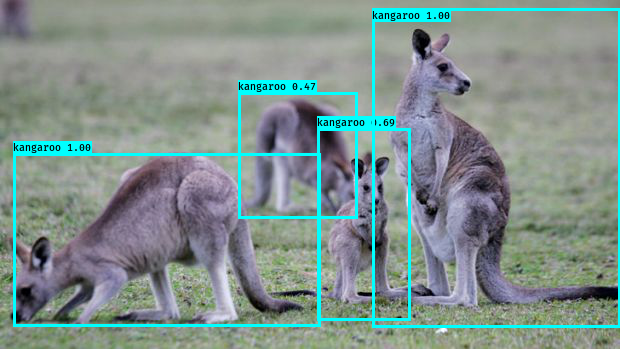

In [4]:
r_image

## 驗證影片

我這裡是用遠端主機，無法使用`cv2.imshow()`函式，所以就不參考repo中的`detect_video`方法了，自己寫影片轉換程式。

In [3]:
from yolo import YOLO
log_dir = 'logs/000/'
classes_path = 'model_data/animal_classes.txt'
yolo_model = YOLO(model_path=log_dir + 'ep120-loss13.537-val_loss14.037.h5', classes_path=classes_path)

Using TensorFlow backend.


logs/000/ep120-loss13.537-val_loss14.037.h5 model, anchors, and classes loaded.


In [6]:
import cv2
import numpy as np
from PIL import Image
import timeit

starttime = timeit.default_timer()
cap = cv2.VideoCapture('Kangaroo.mp4')

# 使用 XVID 編碼
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# 建立 VideoWriter 物件，輸出影片至 output.avi
# FPS 值為 30.0，解析度為 1280*720
out = cv2.VideoWriter('Kangaroo-object-detection.avi', fourcc, 30.0, (1280, 720))

k = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # 寫入影格
        image = Image.fromarray(frame)
        image = np.array(yolo_model.detect_image(image))
        out.write(image)
        k += 1
    else:
        break
    
# 釋放所有資源
cap.release()
out.release()

print('共耗時:',round((timeit.default_timer() - starttime), 2), '秒，FPS:', round(k/(timeit.default_timer() - starttime), 2))

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (589, 454) (1110, 668)
0.06847147271037102
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (589, 454) (1109, 668)
0.05858103185892105
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (118, 0) (751, 677)
kangaroo 0.63 (589, 455) (1110, 669)
0.05689786374568939
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (317, 0) (738, 720)
kangaroo 0.47 (600, 447) (1090, 678)
0.05629946291446686
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (305, 0) (751, 720)
kangaroo 0.55 (603, 456) (1097, 683)
0.06081048771739006
(416, 416, 3)
Found 0 boxes for img
0.058667317032814026
(416, 416, 3)
Found 0 boxes for img
0.049632247537374496
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (0, 0) (559, 547)
0.05531236529350281
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (610, 464) (1102, 675)
0.05042100325226784
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.35 (643, 464) (1075, 667)
0.05239827558398247
(416, 416, 3)
Found 2 boxes for img
kangaroo 

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (290, 142) (553, 621)
kangaroo 0.61 (724, 436) (909, 656)
0.05225180834531784
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (292, 141) (553, 621)
kangaroo 0.56 (724, 437) (911, 651)
0.05490029603242874
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (290, 140) (554, 621)
kangaroo 0.57 (724, 437) (911, 651)
0.05190098658204079
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (297, 144) (553, 627)
kangaroo 0.54 (719, 435) (918, 653)
0.05112900957465172
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (301, 143) (552, 626)
kangaroo 0.58 (721, 431) (915, 657)
0.051544252783060074
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (304, 143) (552, 624)
kangaroo 0.61 (722, 433) (914, 656)
0.051503028720617294
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (305, 144) (552, 623)
kangaroo 0.64 (723, 436) (912, 652)
0.05842272564768791
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (304, 141) (553, 625)
kangaroo 0.64 (723, 435) (912,

(416, 416, 3)
Found 2 boxes for img
raccoon 0.79 (501, 36) (1015, 691)
kangaroo 0.31 (570, 56) (1051, 677)
0.0514993779361248
(416, 416, 3)
Found 2 boxes for img
raccoon 0.65 (501, 31) (1015, 688)
kangaroo 0.49 (578, 59) (1045, 668)
0.05794128030538559
(416, 416, 3)
Found 2 boxes for img
raccoon 0.65 (501, 31) (1015, 688)
kangaroo 0.49 (578, 59) (1045, 668)
0.05267449468374252
(416, 416, 3)
Found 2 boxes for img
raccoon 0.71 (508, 35) (1010, 684)
kangaroo 0.46 (577, 60) (1044, 663)
0.05710506811738014
(416, 416, 3)
Found 2 boxes for img
raccoon 0.58 (500, 24) (1021, 686)
kangaroo 0.51 (583, 51) (1046, 661)
0.056537117809057236
(416, 416, 3)
Found 2 boxes for img
raccoon 0.65 (505, 32) (1017, 685)
kangaroo 0.46 (579, 52) (1051, 666)
0.052900202572345734
(416, 416, 3)
Found 2 boxes for img
raccoon 0.52 (506, 35) (1017, 682)
kangaroo 0.56 (578, 53) (1052, 665)
0.06023281067609787
(416, 416, 3)
Found 2 boxes for img
raccoon 0.52 (506, 35) (1017, 682)
kangaroo 0.56 (577, 53) (1052, 665)
0.0

Found 1 boxes for img
kangaroo 0.91 (14, 0) (1236, 720)
0.05017557367682457
(416, 416, 3)
Found 2 boxes for img
raccoon 0.38 (0, 0) (1280, 696)
kangaroo 0.73 (19, 0) (1110, 720)
0.05515062063932419
(416, 416, 3)
Found 2 boxes for img
raccoon 0.38 (0, 0) (1280, 695)
kangaroo 0.75 (22, 0) (1107, 720)
0.0566239170730114
(416, 416, 3)
Found 2 boxes for img
raccoon 0.63 (0, 0) (1182, 720)
kangaroo 0.45 (0, 0) (1273, 720)
0.05753711238503456
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (0, 11) (1195, 697)
0.05070727691054344
(416, 416, 3)
Found 2 boxes for img
raccoon 0.41 (0, 34) (1147, 667)
kangaroo 0.55 (0, 34) (1147, 667)
0.050658293068408966
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (0, 48) (1223, 648)
0.05706251785159111
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (0, 46) (1220, 649)
0.06060096621513367
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (0, 25) (1085, 650)
0.058316849172115326
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (0, 23) (1070, 650)
0.05113

(416, 416, 3)
Found 5 boxes for img
kangaroo 0.34 (371, 401) (1127, 704)
kangaroo 0.62 (370, 97) (686, 385)
kangaroo 0.64 (821, 226) (1080, 523)
kangaroo 0.81 (81, 0) (343, 485)
kangaroo 0.83 (668, 391) (970, 703)
0.0591195710003376
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.44 (399, 404) (1099, 708)
kangaroo 0.60 (365, 120) (686, 369)
kangaroo 0.65 (812, 227) (1082, 526)
kangaroo 0.82 (671, 392) (969, 704)
kangaroo 0.83 (80, 0) (348, 480)
0.05529380217194557
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.42 (391, 407) (1107, 704)
kangaroo 0.57 (368, 118) (685, 369)
kangaroo 0.68 (815, 229) (1081, 525)
kangaroo 0.82 (79, 0) (352, 482)
kangaroo 0.83 (670, 394) (969, 702)
0.057932935655117035
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.50 (385, 404) (1113, 704)
kangaroo 0.58 (363, 122) (693, 380)
kangaroo 0.59 (815, 235) (1086, 521)
kangaroo 0.76 (665, 392) (967, 703)
kangaroo 0.85 (84, 0) (350, 478)
0.05959244444966316
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.43 (365, 132) 

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.43 (308, 94) (362, 188)
kangaroo 0.68 (825, 396) (898, 499)
0.050383102148771286
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (309, 92) (361, 189)
kangaroo 0.67 (825, 395) (897, 500)
0.0506754107773304
(416, 416, 3)
Found 0 boxes for img
0.046683169901371
(416, 416, 3)
Found 0 boxes for img
0.047046177089214325
(416, 416, 3)
Found 0 boxes for img
0.048424966633319855
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (357, 87) (405, 212)
0.056085824966430664
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (357, 86) (405, 213)
0.05066608265042305
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.49 (1045, 92) (1095, 156)
0.05819190293550491
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (388, 72) (420, 218)
kangaroo 0.34 (1040, 80) (1115, 165)
0.06369833648204803
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (935, 385) (1061, 471)
kangaroo 0.43 (1069, 86) (1118, 154)
0.0615525022149086
(416, 416, 3)
Found 1 boxes for img
kangaroo 

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.38 (27, 376) (178, 506)
kangaroo 0.41 (232, 15) (284, 121)
kangaroo 0.44 (0, 304) (185, 584)
kangaroo 0.85 (930, 342) (1104, 519)
0.05302708223462105
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (2, 343) (205, 537)
kangaroo 0.90 (927, 329) (1176, 524)
0.05304852873086929
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (2, 344) (205, 536)
kangaroo 0.90 (927, 330) (1177, 524)
0.05960657075047493
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (958, 355) (1181, 510)
0.05927804484963417
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (1024, 86) (1074, 201)
kangaroo 0.86 (970, 344) (1210, 529)
0.052437201142311096
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.52 (1040, 94) (1098, 191)
kangaroo 0.91 (931, 350) (1274, 531)
0.057069312781095505
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.44 (559, 171) (752, 534)
kangaroo 0.77 (368, 370) (767, 720)
kangaroo 0.82 (265, 134) (466, 341)
kangaroo 0.83 (865, 461) (1263, 688)
0.06198366731

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.62 (680, 237) (931, 517)
kangaroo 0.86 (0, 98) (192, 459)
kangaroo 0.93 (590, 391) (881, 694)
0.05505680292844772
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.62 (680, 237) (931, 516)
kangaroo 0.86 (0, 97) (192, 460)
kangaroo 0.93 (590, 391) (881, 694)
0.05524342879652977
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.40 (373, 144) (527, 346)
kangaroo 0.65 (673, 239) (938, 515)
kangaroo 0.86 (0, 105) (192, 453)
kangaroo 0.94 (594, 392) (885, 691)
0.055960629135370255
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.66 (377, 102) (531, 375)
kangaroo 0.66 (0, 71) (191, 477)
kangaroo 0.73 (680, 244) (933, 508)
kangaroo 0.92 (596, 400) (889, 695)
0.06004663184285164
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.64 (0, 81) (206, 460)
kangaroo 0.77 (681, 241) (935, 510)
kangaroo 0.78 (385, 72) (525, 385)
kangaroo 0.92 (592, 399) (892, 693)
0.055300597101449966
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.71 (0, 84) (210, 456)
kangaroo 0.78 (6

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (627, 70) (1068, 675)
0.05417565628886223
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (644, 65) (1063, 683)
0.055964451283216476
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (687, 68) (1113, 684)
0.05710544064640999
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (678, 57) (1124, 691)
0.05307834967970848
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.75 (690, 49) (1118, 701)
0.05034104734659195
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (690, 47) (1119, 703)
0.059172678738832474
(416, 416, 3)
Found 2 boxes for img
raccoon 0.43 (691, 45) (1122, 707)
kangaroo 0.42 (691, 45) (1122, 707)
0.05822272598743439
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (700, 59) (1119, 693)
0.04808105528354645
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (702, 51) (1123, 701)
0.0496005043387413
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (706, 52) (1119, 702)
0.049993064254522324
(416, 416, 3)
Found 1 boxes for img
kangaro

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.67 (706, 328) (1118, 481)
kangaroo 0.99 (144, 262) (794, 704)
0.04834995046257973
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.67 (707, 328) (1118, 481)
kangaroo 0.99 (141, 265) (797, 702)
0.05227898806333542
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.57 (694, 312) (1113, 494)
kangaroo 0.98 (207, 251) (815, 720)
0.058962494134902954
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.89 (673, 299) (1019, 554)
kangaroo 0.98 (171, 246) (863, 720)
0.052893150597810745
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.44 (663, 290) (1026, 600)
kangaroo 0.81 (235, 280) (829, 695)
0.051743440330028534
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (93, 259) (771, 682)
kangaroo 0.42 (668, 323) (986, 595)
0.052354827523231506
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (315, 344) (1170, 598)
kangaroo 0.44 (667, 323) (984, 594)
kangaroo 0.47 (85, 259) (777, 677)
0.06001178175210953
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (143, 243)

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (642, 123) (995, 633)
0.05691790208220482
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (1072, 38) (1155, 326)
kangaroo 0.92 (633, 134) (1002, 636)
0.05945803225040436
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (1072, 38) (1155, 326)
kangaroo 0.92 (633, 134) (1002, 635)
0.061337508261203766
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.45 (1073, 45) (1150, 316)
kangaroo 0.94 (635, 131) (1005, 638)
0.05095358192920685
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (1066, 37) (1154, 317)
kangaroo 0.95 (639, 130) (1010, 633)
0.051970042288303375
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (640, 130) (1012, 631)
0.050866249948740005
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (632, 123) (1018, 636)
0.04995084926486015
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (631, 123) (1018, 637)
0.05703401565551758
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (632, 116) (1020, 637)
0.05726185068488121
(416, 416, 3)

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (92, 0) (1211, 720)
0.051695190370082855
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (100, 0) (1207, 708)
0.05771792307496071
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (116, 0) (1205, 715)
0.057995617389678955
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (110, 0) (1209, 720)
0.05626359209418297
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (228, 30) (1264, 673)
0.053720712661743164
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (271, 13) (1231, 685)
0.05785546824336052
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (392, 0) (1269, 702)
0.05490187928080559
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (478, 0) (1203, 720)
0.05115607753396034
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (481, 0) (1199, 720)
0.049837399274110794
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (488, 0) (1202, 720)
0.053440555930137634
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (494, 0) (1194, 720)
0.05055288225412369
(416

(416, 416, 3)
Found 2 boxes for img
raccoon 0.56 (0, 0) (1191, 689)
kangaroo 0.90 (0, 0) (1280, 616)
0.05287570878863335
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (0, 0) (1280, 635)
0.050586238503456116
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 0) (1269, 718)
0.050084978342056274
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 0) (1267, 719)
0.049082811921834946
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (19, 0) (1246, 713)
0.050267741084098816
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (46, 5) (1207, 694)
0.05687147378921509
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (3, 0) (1256, 715)
0.05392714589834213
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (66, 13) (1199, 683)
0.057692158967256546
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (66, 10) (1196, 686)
0.0535205639898777
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (46, 4) (1215, 692)
0.049230802804231644
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (56, 0) (1184, 7

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (53, 114) (1214, 720)
0.05381165072321892
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (54, 113) (1213, 720)
0.054396018385887146
(416, 416, 3)
Found 2 boxes for img
raccoon 0.59 (0, 106) (1280, 668)
kangaroo 0.75 (21, 106) (1224, 720)
0.05303894355893135
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (17, 122) (1257, 720)
0.0502934455871582
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 123) (1279, 720)
0.05007590726017952
(416, 416, 3)
Found 2 boxes for img
raccoon 0.61 (0, 82) (1272, 680)
kangaroo 0.82 (18, 127) (1250, 720)
0.05320589989423752
(416, 416, 3)
Found 2 boxes for img
raccoon 0.60 (0, 88) (1280, 674)
kangaroo 0.82 (11, 129) (1255, 720)
0.05192042142152786
(416, 416, 3)
Found 2 boxes for img
raccoon 0.62 (0, 44) (1280, 702)
kangaroo 0.93 (0, 130) (1280, 720)
0.05190880596637726
(416, 416, 3)
Found 2 boxes for img
raccoon 0.43 (0, 64) (1280, 687)
kangaroo 0.86 (0, 129) (1280, 720)
0.05265609920024872
(416, 416

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.98 (0, 0) (1195, 613)
0.056366559118032455
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.99 (0, 0) (1127, 598)
0.049073029309511185
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (0, 0) (1143, 615)
0.04867882281541824
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (0, 0) (1147, 612)
0.05894644558429718
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.97 (0, 0) (1143, 601)
0.05790461227297783
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (276, 43) (1135, 448)
kangaroo 0.89 (8, 0) (1244, 594)
0.05290718749165535
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (73, 0) (1185, 607)
0.05286949500441551
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (0, 0) (1175, 625)
0.0501224547624588
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (0, 0) (1171, 627)
0.05148014798760414
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (0, 0) (1161, 605)
0.04994849115610123
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.96 (0, 0) (1204, 718)
0.0

Found 1 boxes for img
kangaroo 0.49 (462, 494) (495, 536)
0.05486427992582321
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.31 (637, 447) (665, 536)
kangaroo 0.31 (1037, 436) (1106, 644)
kangaroo 0.31 (952, 309) (998, 485)
kangaroo 0.41 (853, 363) (940, 620)
kangaroo 0.45 (464, 491) (495, 541)
0.056066304445266724
(416, 416, 3)
Found 6 boxes for img
kangaroo 0.32 (481, 269) (535, 312)
kangaroo 0.33 (826, 385) (937, 615)
kangaroo 0.34 (1004, 444) (1098, 638)
kangaroo 0.35 (852, 435) (936, 564)
kangaroo 0.41 (562, 487) (600, 540)
kangaroo 0.42 (944, 339) (1006, 491)
0.05691658705472946
(416, 416, 3)
Found 6 boxes for img
kangaroo 0.32 (481, 269) (535, 312)
kangaroo 0.33 (826, 385) (937, 615)
kangaroo 0.34 (1004, 444) (1098, 638)
kangaroo 0.35 (852, 435) (935, 564)
kangaroo 0.41 (562, 487) (601, 540)
kangaroo 0.42 (944, 339) (1006, 491)
0.05670977756381035
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.34 (480, 270) (535, 311)
kangaroo 0.45 (625, 405) (712, 544)
kangaroo 0.47 (1012, 461)

Found 0 boxes for img
0.04748627543449402
(416, 416, 3)
Found 0 boxes for img
0.04695821553468704
(416, 416, 3)
Found 0 boxes for img
0.04807579889893532
(416, 416, 3)
Found 0 boxes for img
0.04802263155579567
(416, 416, 3)
Found 0 boxes for img
0.052674002945423126
(416, 416, 3)
Found 0 boxes for img
0.049482520669698715
(416, 416, 3)
Found 0 boxes for img
0.050921157002449036
(416, 416, 3)
Found 0 boxes for img
0.047560110688209534
(416, 416, 3)
Found 0 boxes for img
0.04869961366057396
(416, 416, 3)
Found 0 boxes for img
0.048272497951984406
(416, 416, 3)
Found 0 boxes for img
0.04387011006474495
(416, 416, 3)
Found 0 boxes for img
0.04770372435450554
(416, 416, 3)
Found 0 boxes for img
0.04648976773023605
(416, 416, 3)
Found 0 boxes for img
0.05592401325702667
(416, 416, 3)
Found 0 boxes for img
0.04730191081762314
(416, 416, 3)
Found 0 boxes for img
0.04845716059207916
(416, 416, 3)
Found 0 boxes for img
0.04399227350950241
(416, 416, 3)
Found 0 boxes for img
0.044938407838344574


Found 0 boxes for img
0.04865552857518196
(416, 416, 3)
Found 0 boxes for img
0.05090675875544548
(416, 416, 3)
Found 0 boxes for img
0.04787577688694
(416, 416, 3)
Found 0 boxes for img
0.051996346563100815
(416, 416, 3)
Found 0 boxes for img
0.052262987941503525
(416, 416, 3)
Found 0 boxes for img
0.047165483236312866
(416, 416, 3)
Found 0 boxes for img
0.049115139991045
(416, 416, 3)
Found 0 boxes for img
0.047052424401044846
(416, 416, 3)
Found 0 boxes for img
0.04709506779909134
(416, 416, 3)
Found 0 boxes for img
0.048288069665431976
(416, 416, 3)
Found 0 boxes for img
0.048328697681427
(416, 416, 3)
Found 0 boxes for img
0.048429202288389206
(416, 416, 3)
Found 0 boxes for img
0.048313405364751816
(416, 416, 3)
Found 0 boxes for img
0.04802563786506653
(416, 416, 3)
Found 0 boxes for img
0.054836638271808624
(416, 416, 3)
Found 0 boxes for img
0.05404578894376755
(416, 416, 3)
Found 0 boxes for img
0.05458010360598564
(416, 416, 3)
Found 0 boxes for img
0.047932300716638565
(416

(416, 416, 3)
Found 0 boxes for img
0.04777149483561516
(416, 416, 3)
Found 0 boxes for img
0.04652496799826622
(416, 416, 3)
Found 0 boxes for img
0.04691249877214432
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (550, 243) (913, 527)
0.048756714910268784
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (600, 227) (867, 527)
0.04842233657836914
(416, 416, 3)
Found 0 boxes for img
0.046861596405506134
(416, 416, 3)
Found 0 boxes for img
0.04656108468770981
(416, 416, 3)
Found 0 boxes for img
0.04708355292677879
(416, 416, 3)
Found 0 boxes for img
0.05326899513602257
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (593, 180) (883, 672)
0.051216620951890945
(416, 416, 3)
Found 0 boxes for img
0.05151829496026039
(416, 416, 3)
Found 0 boxes for img
0.05435868725180626
(416, 416, 3)
Found 0 boxes for img
0.05134531855583191
(416, 416, 3)
Found 0 boxes for img
0.04894191771745682
(416, 416, 3)
Found 0 boxes for img
0.054325271397829056
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (4

Found 1 boxes for img
raccoon 0.89 (433, 228) (967, 706)
0.04955620691180229
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (426, 225) (972, 706)
0.04870022460818291
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (444, 225) (958, 699)
0.05059218406677246
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (444, 227) (958, 698)
0.052221838384866714
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (447, 226) (957, 698)
0.050170887261629105
(416, 416, 3)
Found 3 boxes for img
raccoon 0.43 (328, 195) (566, 563)
raccoon 0.64 (438, 176) (900, 720)
kangaroo 0.49 (505, 255) (914, 694)
0.05289435759186745
(416, 416, 3)
Found 2 boxes for img
raccoon 0.34 (321, 179) (559, 596)
kangaroo 0.54 (491, 249) (926, 700)
0.05040301755070686
(416, 416, 3)
Found 2 boxes for img
raccoon 0.40 (317, 187) (557, 586)
kangaroo 0.57 (454, 229) (947, 704)
0.05133996903896332
(416, 416, 3)
Found 2 boxes for img
raccoon 0.41 (306, 203) (549, 570)
kangaroo 0.76 (450, 248) (957, 683)
0.052868399769067764
(416, 416, 3)

kangaroo 0.67 (88, 394) (432, 603)
kangaroo 0.82 (992, 405) (1226, 564)
0.05640805885195732
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.68 (396, 312) (603, 617)
kangaroo 0.76 (88, 395) (433, 600)
kangaroo 0.78 (978, 402) (1237, 566)
0.05450892820954323
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.73 (403, 325) (596, 604)
kangaroo 0.77 (91, 384) (430, 611)
kangaroo 0.79 (988, 403) (1229, 569)
0.06353412196040154
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.70 (77, 379) (450, 604)
kangaroo 0.73 (397, 325) (606, 601)
kangaroo 0.73 (977, 399) (1239, 571)
0.06032833456993103
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.45 (102, 368) (406, 595)
kangaroo 0.68 (407, 333) (595, 567)
kangaroo 0.79 (970, 402) (1233, 568)
0.05724232643842697
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.45 (100, 373) (409, 590)
kangaroo 0.77 (403, 327) (597, 569)
kangaroo 0.78 (969, 402) (1234, 568)
0.060071222484111786
(416, 416, 3)
Found 5 boxes for img
raccoon 0.39 (533, 124) (973, 585)
kangaroo 0.31 

Found 3 boxes for img
kangaroo 0.33 (411, 196) (725, 644)
kangaroo 0.58 (788, 254) (955, 555)
kangaroo 0.71 (166, 330) (354, 569)
0.05989788845181465
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (412, 201) (723, 640)
kangaroo 0.55 (791, 238) (951, 572)
kangaroo 0.70 (166, 331) (350, 566)
0.053419534116983414
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.38 (416, 194) (721, 649)
kangaroo 0.55 (785, 235) (960, 572)
kangaroo 0.76 (168, 327) (348, 569)
0.05379140004515648
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.37 (414, 198) (723, 647)
kangaroo 0.55 (794, 230) (952, 570)
kangaroo 0.77 (169, 328) (349, 571)
0.05513165891170502
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.30 (285, 393) (527, 568)
kangaroo 0.34 (401, 212) (727, 634)
kangaroo 0.51 (804, 211) (946, 584)
kangaroo 0.76 (174, 334) (344, 565)
0.05637426674365997
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (401, 211) (728, 634)
kangaroo 0.51 (804, 212) (946, 584)
kangaroo 0.76 (174, 333) (343, 565)
0.05287365987

Found 3 boxes for img
kangaroo 0.35 (97, 348) (317, 587)
kangaroo 0.50 (766, 280) (941, 572)
kangaroo 0.81 (366, 280) (647, 622)
0.05476124957203865
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (76, 300) (287, 604)
kangaroo 0.58 (763, 272) (943, 576)
kangaroo 0.83 (360, 292) (648, 623)
0.05435812100768089
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.36 (79, 310) (280, 592)
kangaroo 0.77 (759, 255) (945, 592)
kangaroo 0.81 (365, 290) (638, 630)
0.05538829043507576
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.36 (78, 309) (282, 592)
kangaroo 0.76 (759, 255) (945, 593)
kangaroo 0.82 (365, 291) (637, 630)
0.0538916289806366
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (78, 316) (281, 588)
kangaroo 0.81 (769, 258) (937, 586)
kangaroo 0.86 (365, 314) (635, 627)
0.0577220544219017
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (79, 335) (285, 612)
kangaroo 0.64 (379, 301) (620, 639)
kangaroo 0.80 (765, 261) (942, 587)
0.05878058448433876
(416, 416, 3)
Found 3 boxes for img
ka

Found 1 boxes for img
kangaroo 0.82 (233, 36) (1280, 657)
0.048760462552309036
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.76 (265, 60) (1280, 647)
0.04854603484272957
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (289, 47) (1280, 670)
0.04829397052526474
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (278, 44) (1280, 678)
0.04772801697254181
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48 (324, 42) (1280, 664)
0.049671053886413574
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (381, 24) (1280, 676)
0.04927583411335945
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (463, 0) (1222, 712)
0.052074555307626724
(416, 416, 3)
Found 0 boxes for img
0.04713381081819534
(416, 416, 3)
Found 0 boxes for img
0.04844957962632179
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (519, 0) (1280, 720)
0.04764493554830551
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (520, 0) (1280, 720)
0.04885974898934364
(416, 416, 3)
Found 2 boxes for img
raccoon 0.44 (523, 0) (1280, 711)
kangar

In [7]:
starttime = timeit.default_timer()
cap = cv2.VideoCapture('Raccoon.mp4')

# 使用 XVID 編碼
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# 建立 VideoWriter 物件，輸出影片至 output.avi
# FPS 值為 30.0，解析度為 1280*720
out = cv2.VideoWriter('Raccoon-object-detection.avi', fourcc, 30.0, (1280, 720))

k = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # 寫入影格
        image = Image.fromarray(frame)
        image = np.array(yolo_model.detect_image(image))
        out.write(image)
        k += 1
    else:
        break
    
# 釋放所有資源
cap.release()
out.release()

print('共耗時:',round((timeit.default_timer() - starttime), 2), '秒，FPS:', round(k/(timeit.default_timer() - starttime), 2))

(416, 416, 3)
Found 0 boxes for img
0.05319983884692192
(416, 416, 3)
Found 0 boxes for img
0.049757976084947586
(416, 416, 3)
Found 0 boxes for img
0.05070788413286209
(416, 416, 3)
Found 0 boxes for img
0.05820702388882637
(416, 416, 3)
Found 0 boxes for img
0.04984999820590019
(416, 416, 3)
Found 0 boxes for img
0.05102674663066864
(416, 416, 3)
Found 0 boxes for img
0.05048229172825813
(416, 416, 3)
Found 0 boxes for img
0.05717189610004425
(416, 416, 3)
Found 0 boxes for img
0.04906507208943367
(416, 416, 3)
Found 0 boxes for img
0.04894225299358368
(416, 416, 3)
Found 0 boxes for img
0.05087443068623543
(416, 416, 3)
Found 0 boxes for img
0.04963667318224907
(416, 416, 3)
Found 0 boxes for img
0.05500761792063713
(416, 416, 3)
Found 0 boxes for img
0.05067923665046692
(416, 416, 3)
Found 0 boxes for img
0.04951998591423035
(416, 416, 3)
Found 0 boxes for img
0.0530080646276474
(416, 416, 3)
Found 0 boxes for img
0.054264672100543976
(416, 416, 3)
Found 0 boxes for img
0.056686412

Found 0 boxes for img
0.04597293213009834
(416, 416, 3)
Found 0 boxes for img
0.04545930400490761
(416, 416, 3)
Found 0 boxes for img
0.05812831223011017
(416, 416, 3)
Found 0 boxes for img
0.05069505795836449
(416, 416, 3)
Found 0 boxes for img
0.04860503226518631
(416, 416, 3)
Found 0 boxes for img
0.04720649495720863
(416, 416, 3)
Found 0 boxes for img
0.04835382103919983
(416, 416, 3)
Found 0 boxes for img
0.05183982476592064
(416, 416, 3)
Found 0 boxes for img
0.05384988337755203
(416, 416, 3)
Found 0 boxes for img
0.054472438991069794
(416, 416, 3)
Found 0 boxes for img
0.048293162137269974
(416, 416, 3)
Found 0 boxes for img
0.04710681363940239
(416, 416, 3)
Found 0 boxes for img
0.05494115501642227
(416, 416, 3)
Found 0 boxes for img
0.0472119003534317
(416, 416, 3)
Found 0 boxes for img
0.0492476187646389
(416, 416, 3)
Found 0 boxes for img
0.04725745692849159
(416, 416, 3)
Found 0 boxes for img
0.05534132942557335
(416, 416, 3)
Found 0 boxes for img
0.054972533136606216
(416,

(416, 416, 3)
Found 0 boxes for img
0.04753868281841278
(416, 416, 3)
Found 0 boxes for img
0.04705346003174782
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (482, 6) (1236, 565)
0.054309532046318054
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (474, 14) (1248, 569)
0.0537334606051445
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (470, 19) (1250, 571)
0.05713443085551262
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (456, 20) (1265, 574)
0.057026419788599014
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (445, 20) (1278, 576)
0.05670548230409622
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (456, 25) (1278, 568)
0.05604085326194763
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (447, 11) (1279, 578)
0.05429507791996002
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (449, 15) (1280, 568)
0.04912131652235985
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (448, 19) (1280, 555)
0.049042101949453354
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (445, 0) (1280, 577

Found 0 boxes for img
0.052327416837215424
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (262, 88) (1053, 557)
0.051532499492168427
(416, 416, 3)
Found 1 boxes for img
raccoon 0.50 (247, 83) (1075, 562)
0.04894793778657913
(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (258, 93) (1072, 556)
0.050017256289720535
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (227, 74) (1109, 583)
0.04967409372329712
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (260, 87) (1173, 577)
0.05039335414767265
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (278, 88) (1155, 588)
0.058073922991752625
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (273, 104) (1166, 578)
0.05150500312447548
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (261, 107) (1175, 587)
0.05222528800368309
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (250, 103) (1199, 605)
0.04804813489317894
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (238, 105) (1209, 613)
0.05067067593336105
(416, 416, 3)
Found 1 boxes for img
racc

(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (26, 0) (1260, 720)
0.04923227056860924
(416, 416, 3)
Found 1 boxes for img
raccoon 0.36 (0, 0) (1280, 720)
0.05386272072792053
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (0, 0) (1280, 720)
0.04943390563130379
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (0, 0) (1280, 720)
0.05024697631597519
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (0, 0) (1280, 720)
0.05129776895046234
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (0, 0) (1280, 720)
0.05061540752649307
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (0, 0) (1280, 720)
0.049531351774930954
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (0, 0) (1280, 720)
0.05016413703560829
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (0, 0) (1280, 720)
0.04998708516359329
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (0, 0) (1280, 720)
0.05769885331392288
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (0, 0) (1280, 720)
0.05185094103217125
(416, 416, 3)
Found 1 boxes fo

Found 1 boxes for img
raccoon 0.97 (175, 296) (708, 686)
0.0505773201584816
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (166, 298) (714, 686)
0.05282730236649513
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (179, 302) (710, 680)
0.057795241475105286
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (182, 298) (708, 686)
0.05567862093448639
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (176, 299) (711, 682)
0.05225875973701477
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (150, 315) (758, 720)
0.05197802931070328
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (171, 322) (739, 717)
0.0564882755279541
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (160, 329) (745, 712)
0.0567447729408741
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (168, 333) (744, 711)
0.05067245662212372
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (165, 336) (750, 709)
0.05851820483803749
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (164, 336) (751, 708)
0.05621563643217087
(416, 416, 3)
F

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (1, 38) (926, 720)
0.05011638626456261
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 31) (930, 720)
0.04905189573764801
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 31) (929, 720)
0.049113452434539795
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (0, 42) (937, 714)
0.04953517019748688
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (0, 42) (937, 713)
0.048459939658641815
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (0, 55) (949, 710)
0.049154505133628845
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (0, 55) (949, 709)
0.05077902600169182
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (0, 45) (987, 720)
0.05106762424111366
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (0, 45) (989, 720)
0.05292567238211632
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (25, 56) (866, 720)
0.052446965128183365
(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (24, 55) (867, 720)
0.057226311415433884
(416, 416, 3)
Found 1 box

(416, 416, 3)
Found 2 boxes for img
raccoon 0.46 (0, 295) (299, 598)
kangaroo 0.37 (0, 295) (299, 598)
0.05018662288784981
(416, 416, 3)
Found 2 boxes for img
raccoon 0.48 (0, 294) (296, 595)
kangaroo 0.34 (0, 294) (296, 595)
0.0527191162109375
(416, 416, 3)
Found 2 boxes for img
raccoon 0.52 (1, 296) (293, 593)
kangaroo 0.32 (1, 296) (293, 593)
0.0579255111515522
(416, 416, 3)
Found 2 boxes for img
raccoon 0.51 (4, 296) (289, 590)
kangaroo 0.32 (4, 296) (289, 590)
0.05422670394182205
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (6, 298) (285, 589)
0.05119659751653671
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (5, 299) (287, 589)
0.05067414045333862
(416, 416, 3)
Found 2 boxes for img
raccoon 0.56 (5, 297) (290, 590)
kangaroo 0.30 (5, 297) (290, 590)
0.05388038977980614
(416, 416, 3)
Found 2 boxes for img
raccoon 0.53 (3, 297) (293, 592)
kangaroo 0.34 (3, 297) (293, 592)
0.056306593120098114
(416, 416, 3)
Found 2 boxes for img
raccoon 0.52 (3, 299) (294, 590)
kangaroo 0.35 (3

Found 1 boxes for img
raccoon 0.98 (303, 0) (807, 552)
0.05188840255141258
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (316, 0) (899, 583)
0.05114651843905449
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (315, 0) (906, 577)
0.05216153338551521
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (307, 1) (922, 566)
0.05330640822649002
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (288, 0) (943, 576)
0.055213794112205505
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (279, 0) (970, 585)
0.055901117622852325
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (293, 0) (956, 599)
0.05818905681371689
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (292, 11) (971, 583)
0.05672953650355339
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (307, 7) (972, 592)
0.050501592457294464
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (301, 14) (971, 592)
0.049604520201683044
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (318, 0) (961, 666)
0.05225250497460365
(416, 416, 3)
Found 1 boxes f

Found 1 boxes for img
raccoon 1.00 (0, 0) (1081, 720)
0.04817577078938484
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 0) (1065, 720)
0.04932102560997009
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 0) (1084, 720)
0.0526353195309639
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 0) (1087, 720)
0.04903499782085419
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (336, 0) (1190, 601)
0.052583254873752594
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (340, 0) (1178, 600)
0.05414428934454918
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (352, 0) (1170, 604)
0.05530358850955963
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (346, 0) (1173, 596)
0.05642540007829666
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (332, 0) (1185, 598)
0.051738351583480835
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (341, 0) (1165, 604)
0.052030954509973526
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (340, 0) (1159, 595)
0.056281283497810364
(416, 416, 3)
Found 1 boxes f

Found 1 boxes for img
raccoon 0.83 (393, 0) (1155, 654)
0.04877886921167374
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (404, 0) (1143, 651)
0.050490476191043854
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (507, 4) (1143, 674)
0.053604014217853546
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (537, 5) (1118, 687)
0.05137943476438522
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (559, 12) (1112, 684)
0.051965560764074326
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (571, 4) (1101, 686)
0.05160868912935257
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (579, 10) (1091, 690)
0.05337991565465927
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (585, 16) (1074, 688)
0.05116022378206253
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (577, 2) (1087, 704)
0.05053557828068733
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (584, 0) (1081, 706)
0.0502350740134716
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (595, 8) (1080, 701)
0.05032387375831604
(416, 416, 3)
Found

Found 1 boxes for img
raccoon 0.73 (110, 149) (531, 720)
0.05614928901195526
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (115, 136) (531, 720)
0.05356718227267265
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (113, 129) (532, 720)
0.056939005851745605
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (117, 146) (532, 720)
0.04867842420935631
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (115, 155) (536, 719)
0.04822074621915817
(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (323, 55) (736, 662)
0.057322993874549866
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (306, 47) (745, 682)
0.05411020293831825
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (303, 5) (736, 712)
0.05819183215498924
(416, 416, 3)
Found 0 boxes for img
0.05006830021739006
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (296, 88) (727, 667)
0.04882809519767761
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (275, 89) (743, 687)
0.050313495099544525
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (2

Found 1 boxes for img
raccoon 0.81 (257, 95) (781, 720)
0.053169284015893936
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (262, 31) (783, 720)
0.053550004959106445
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (264, 34) (782, 720)
0.05810369551181793
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (263, 83) (799, 720)
0.05494453012943268
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (303, 93) (798, 720)
0.05087130144238472
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (268, 82) (814, 720)
0.049706242978572845
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (265, 5) (795, 720)
0.057339951395988464
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (267, 0) (790, 720)
0.052922867238521576
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (234, 5) (814, 720)
0.05094194784760475
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (239, 0) (811, 720)
0.05121008679270744
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (235, 0) (810, 720)
0.04835814982652664
(416, 416, 3)
Found 1 bo

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (325, 52) (868, 720)
0.05555509030818939
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (320, 43) (875, 720)
0.05088792368769646
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (308, 59) (888, 719)
0.0550951324403286
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (313, 41) (886, 720)
0.052061475813388824
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (320, 29) (879, 720)
0.04892568662762642
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (306, 69) (893, 715)
0.04932614043354988
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (306, 71) (897, 707)
0.058147307485342026
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (308, 47) (898, 720)
0.05066048353910446
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (317, 41) (897, 720)
0.05767778679728508
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (321, 49) (906, 720)
0.057624105364084244
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (309, 48) (928, 720)
0.05192899703979492
(416, 41

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (49, 31) (1231, 643)
0.056302882730960846
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (64, 42) (1231, 637)
0.05866105481982231
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (51, 41) (1255, 642)
0.05673021450638771
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (41, 18) (1261, 649)
0.051838163286447525
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (38, 19) (1264, 650)
0.049211811274290085
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (35, 37) (1268, 640)
0.057512763887643814
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (27, 44) (1280, 638)
0.05795809254050255
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (21, 42) (1280, 643)
0.05415983870625496
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (72, 27) (1243, 653)
0.04967854544520378
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (83, 28) (1231, 644)
0.04926977679133415
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (75, 33) (1236, 631)
0.050012942403554916
(416,

Found 0 boxes for img
0.0495518296957016
(416, 416, 3)
Found 0 boxes for img
0.04764809086918831
(416, 416, 3)
Found 0 boxes for img
0.051974210888147354
(416, 416, 3)
Found 0 boxes for img
0.05056096985936165
(416, 416, 3)
Found 0 boxes for img
0.05394257977604866
(416, 416, 3)
Found 0 boxes for img
0.047329116612672806
(416, 416, 3)
Found 0 boxes for img
0.048759616911411285
(416, 416, 3)
Found 0 boxes for img
0.04669446870684624
(416, 416, 3)
Found 0 boxes for img
0.04710572585463524
(416, 416, 3)
Found 0 boxes for img
0.0469626747071743
(416, 416, 3)
Found 0 boxes for img
0.04844849929213524
(416, 416, 3)
Found 0 boxes for img
0.05127646401524544
(416, 416, 3)
Found 0 boxes for img
0.04957909882068634
(416, 416, 3)
Found 0 boxes for img
0.045069124549627304
(416, 416, 3)
Found 0 boxes for img
0.04798832908272743
(416, 416, 3)
Found 1 boxes for img
raccoon 0.36 (397, 312) (644, 609)
0.051613785326480865
(416, 416, 3)
Found 0 boxes for img
0.05406318977475166
(416, 416, 3)
Found 0 bo

Found 0 boxes for img
0.046696264296770096
(416, 416, 3)
Found 0 boxes for img
0.04729708284139633
(416, 416, 3)
Found 0 boxes for img
0.04697628319263458
(416, 416, 3)
Found 3 boxes for img
raccoon 0.30 (522, 277) (691, 574)
kangaroo 0.50 (522, 277) (691, 574)
kangaroo 0.69 (107, 248) (547, 720)
0.05340549349784851
(416, 416, 3)
Found 3 boxes for img
raccoon 0.32 (522, 273) (694, 577)
kangaroo 0.50 (522, 273) (694, 577)
kangaroo 0.74 (102, 247) (550, 720)
0.053051307797431946
(416, 416, 3)
Found 3 boxes for img
raccoon 0.40 (518, 269) (697, 578)
kangaroo 0.43 (518, 269) (697, 578)
kangaroo 0.73 (105, 245) (551, 720)
0.052767328917980194
(416, 416, 3)
Found 3 boxes for img
raccoon 0.46 (520, 267) (695, 578)
kangaroo 0.36 (520, 267) (695, 578)
kangaroo 0.71 (104, 247) (553, 720)
0.053243182599544525
(416, 416, 3)
Found 3 boxes for img
raccoon 0.42 (524, 273) (693, 570)
kangaroo 0.43 (524, 273) (693, 570)
kangaroo 0.70 (106, 245) (544, 720)
0.05212794989347458
(416, 416, 3)
Found 3 boxes

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (519, 307) (690, 560)
kangaroo 0.49 (79, 306) (607, 720)
0.06007614731788635
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (642, 215) (1059, 712)
kangaroo 0.43 (522, 299) (687, 563)
kangaroo 0.50 (82, 307) (607, 720)
0.05806993693113327
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.48 (89, 303) (598, 720)
kangaroo 0.49 (519, 307) (688, 555)
kangaroo 0.50 (639, 216) (1052, 714)
0.056247610598802567
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.42 (516, 313) (692, 546)
kangaroo 0.57 (82, 301) (599, 720)
kangaroo 0.62 (643, 224) (1050, 710)
0.05923565849661827
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.37 (514, 314) (691, 542)
kangaroo 0.53 (647, 221) (1052, 711)
kangaroo 0.55 (83, 297) (591, 720)
0.0614694319665432
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.43 (517, 318) (688, 540)
kangaroo 0.47 (80, 296) (586, 720)
kangaroo 0.58 (654, 223) (1047, 709)
0.060099028050899506
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.37 (8

(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (540, 268) (666, 574)
kangaroo 0.36 (540, 268) (666, 574)
0.057013820856809616
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32 (535, 267) (671, 573)
kangaroo 0.42 (535, 267) (671, 573)
0.05997660011053085
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.45 (533, 256) (667, 580)
0.053400542587041855
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (752, 287) (991, 609)
kangaroo 0.48 (531, 255) (664, 579)
0.06057630479335785
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.51 (750, 291) (985, 607)
kangaroo 0.56 (506, 237) (662, 572)
0.06255988404154778
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (747, 294) (985, 600)
kangaroo 0.58 (501, 230) (665, 575)
0.058603111654520035
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (745, 302) (985, 597)
0.05045052245259285
(416, 416, 3)
Found 0 boxes for img
0.05176283046603203
(416, 416, 3)
Found 0 boxes for img
0.05621972307562828
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (750, 265) (9